In [ ]:
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt

In [ ]:
#Read datasets

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

delays_test = pd.read_csv('/content/drive/MyDrive/delays_test.csv')
delays_train = pd.read_csv('/content/drive/MyDrive/delays_train.csv')

In [ ]:
#removed unnecesaary variables
def remove_columns(df, columns_to_drop):

    df_cleaned = df.drop(columns=columns_to_drop)
    return df_cleaned

# List of variables to drop
columns_to_drop = [
    'Flight_Number',
    'Marketing_Airline_DOT_ID',
    'Origin_Airport_ID',
    'Destination_Airport_ID'
]

delays_test = remove_columns(delays_test, columns_to_drop)
delays_train = remove_columns(delays_train, columns_to_drop)

In [ ]:
#Summarize datasets
def summarize_dataset(df):
    print("Dataset Shape:", df.shape)
    print("\nDataset Info:")
    print(df.info())
    print("\nStatistical Summary:")
    print(df.describe())
    print("\nHead values:")
    print(df.head())
    print("\nAmount of missing values:")
    print(df.isna().sum())

In [ ]:
#Check train dataset
summarize_dataset(delays_train)

In [ ]:
#Check test dataset
summarize_dataset(delays_test)

In [ ]:
#Handle missing values
def fill_na_median(series):
    return series.fillna(series.median())

def fill_missing_values_median(df):
    median_fill_columns = {
        'Flight_Distance': [
            ['Departure_State', 'Arrival_State']
        ],
        'Flight_Duration': [
            ['Departure_State', 'Arrival_State'],
            ['Flight_Distance']
        ]
    }

    for column, groupings in median_fill_columns.items():
        for group in groupings:
            df[column] = df.groupby(group)[column].transform(fill_na_median)

    return df

def fill_missing_values(df):
    for column in df.columns:
        df[column].fillna(df[column].mode()[0] if df[column].dtype == 'object' else df[column].mean(), inplace=True)


After Handling Missing Values - Training Dataset: 0

After Handling Missing Values - Test Dataset: 0


In [ ]:
fill_missing_values_median(delays_train)
fill_missing_values_median(delays_test)
fill_missing_values(delays_train)
fill_missing_values(delays_test)

print("\nAfter Handling Missing Values - Training Dataset:", delays_train.isnull().sum().sum())
print("\nAfter Handling Missing Values - Test Dataset:", delays_test.isnull().sum().sum())

In [ ]:
#Encode categorial features for correlation
def encode_categorical_features(df, categorical_features):
    label_encoders = {feature: LabelEncoder().fit(df[feature]) for feature in categorical_features}
    for feature, encoder in label_encoders.items():
        df[feature] = encoder.transform(df[feature])
    return label_encoders

categorical_features = ['Weekday', 'Marketing_Airline', 'Departure_State', 'Arrival_State']
label_encoders_train = encode_categorical_features(delays_train, categorical_features)
label_encoders_test = encode_categorical_features(delays_test, categorical_features)

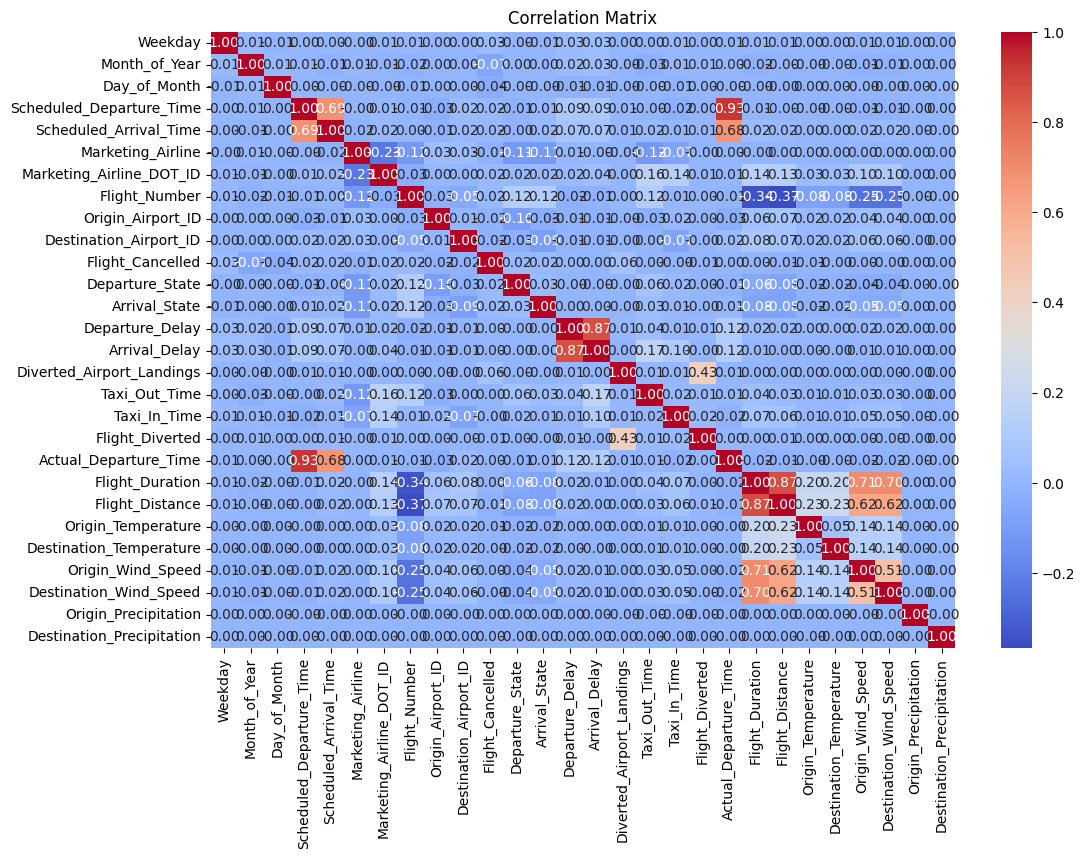

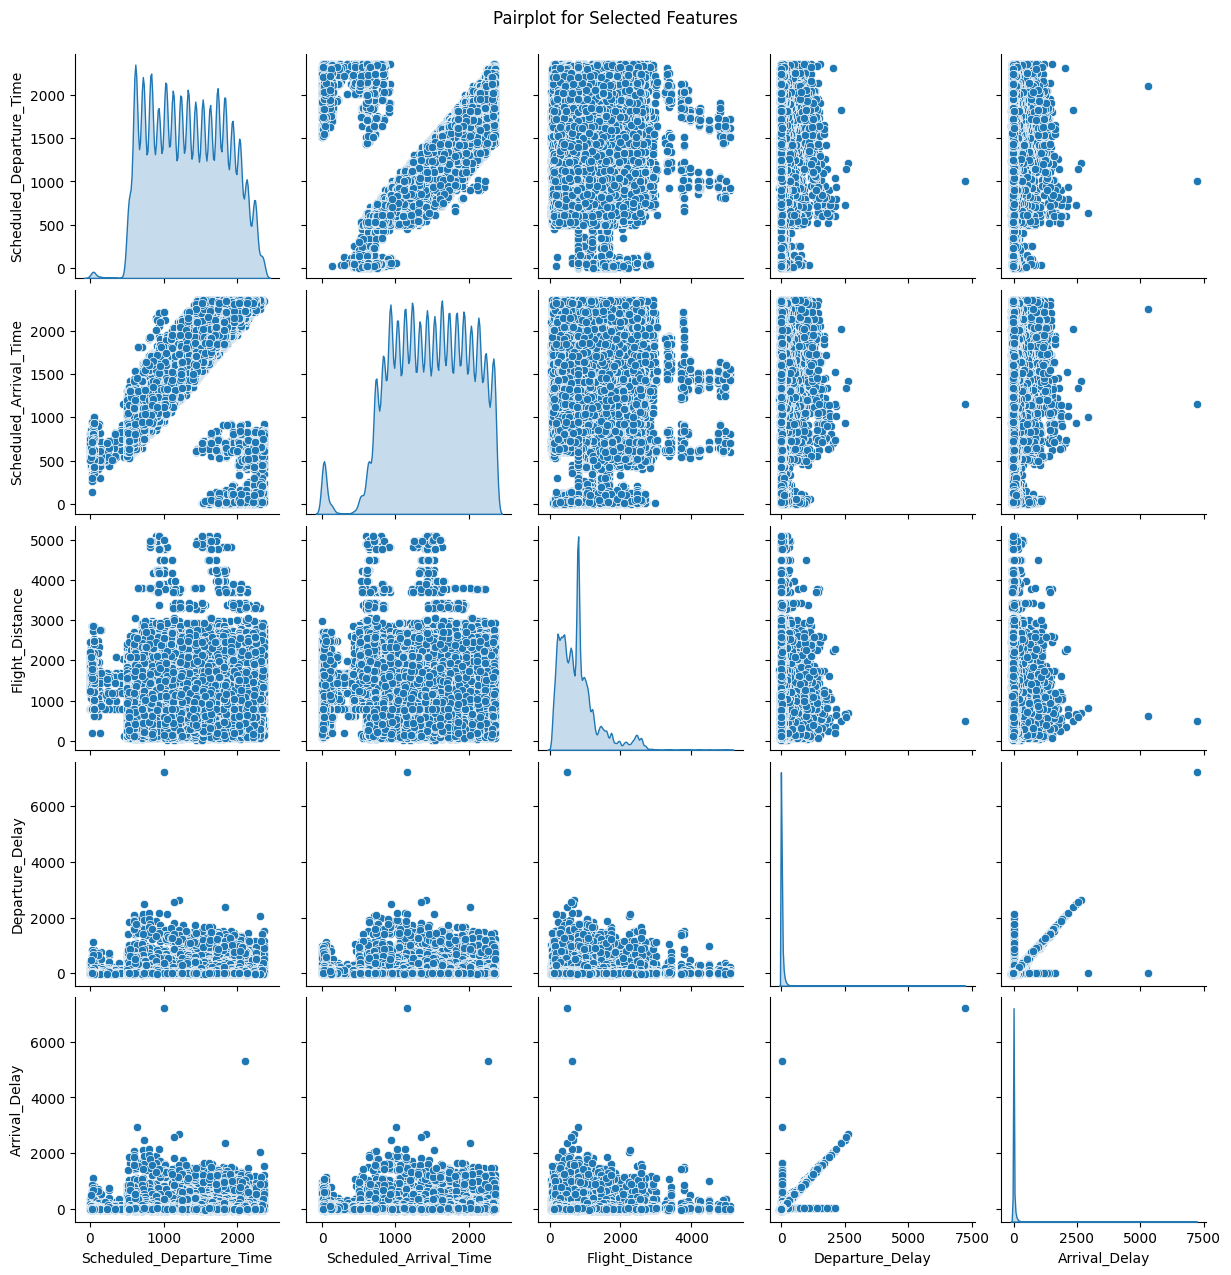

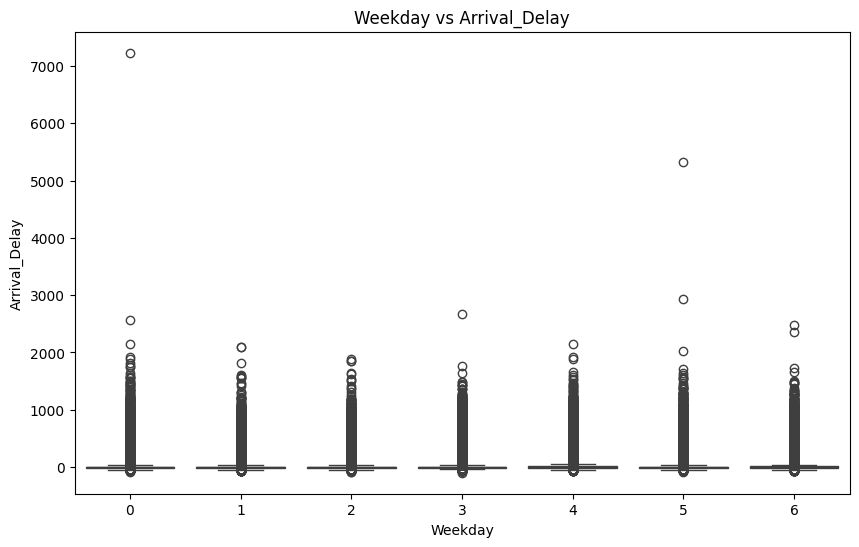

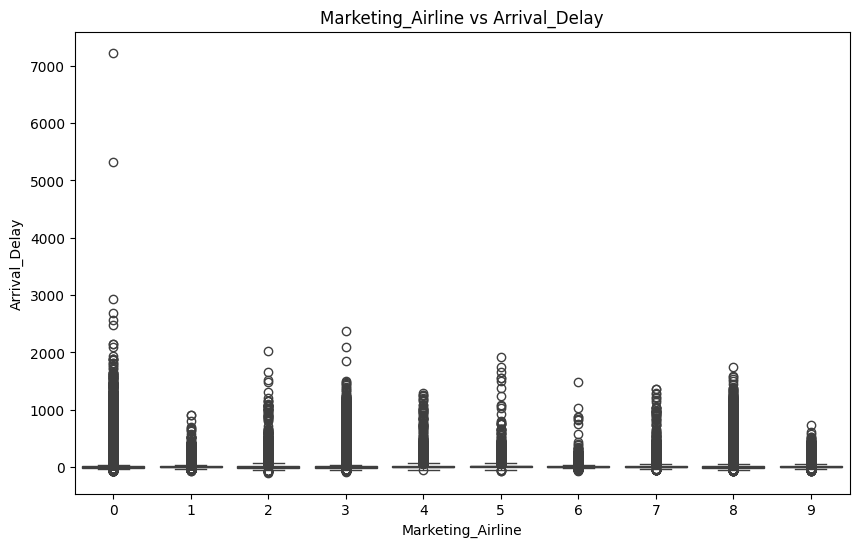

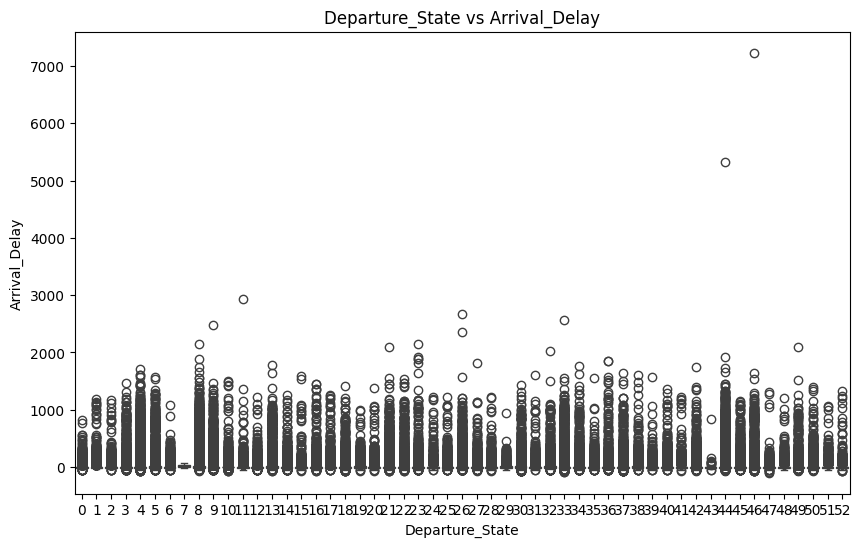

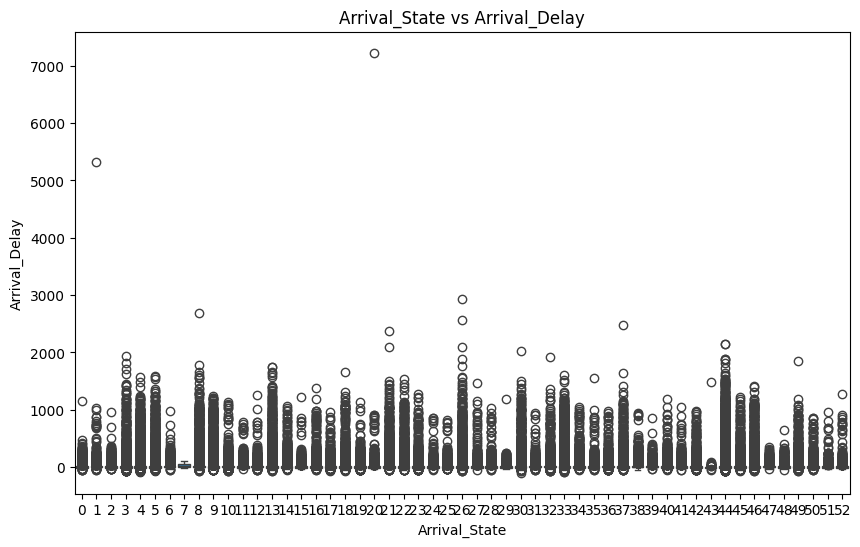

In [ ]:
#Create different types of plots to verify correlation and check outliers
def plot_relationships(df, target_variable, categorical_features):
    plt.figure(figsize=(12, 8))
    sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap='coolwarm')
    plt.title("Correlation Matrix")
    plt.show()
    print()

    selected_features = ['Scheduled_Departure_Time', 'Scheduled_Arrival_Time', 'Flight_Distance', 'Departure_Delay', target_variable]
    sns.pairplot(df[selected_features], diag_kind='kde')
    plt.suptitle("Pairplot for Selected Features", y=1.02)
    plt.show()
    print()

    for feature in categorical_features:
        plt.figure(figsize=(10, 6))
        sns.boxplot(x=feature, y=target_variable, data=df)
        plt.title(f"{feature} vs {target_variable}")
        plt.show()
        print()

plot_relationships(delays_train, 'Arrival_Delay', categorical_features)

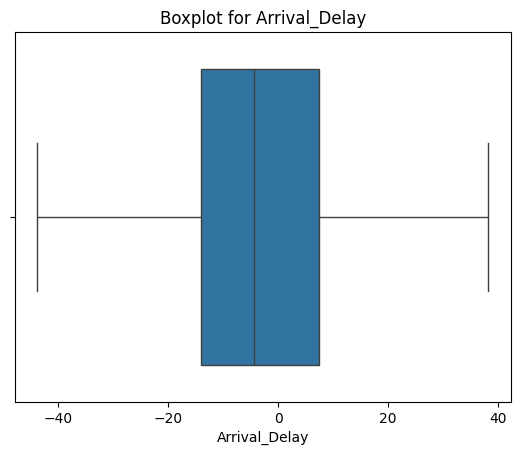

In [ ]:
#Remove outliers
def detect_outliers(df, feature):
    sns.boxplot(x=df[feature])
    plt.title(f"Boxplot for {feature}")
    plt.show()

def remove_outliers(df, features):
    for feature in features:
        Q1, Q3 = df[feature].quantile([0.25, 0.75])
        IQR = Q3 - Q1
        lower_bound, upper_bound = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
        df = df[(df[feature] >= lower_bound) & (df[feature] <= upper_bound)]
    return df

delays_train_cleaned = remove_outliers(delays_train, ['Arrival_Delay'])
detect_outliers(delays_train_cleaned, 'Arrival_Delay')

In [ ]:
#Remove additional variables after correlation matrix results
another_columns_to_drop = [
    'Actual_Departure_Time',
    'Flight_Duration',
    'Departure_Delay'
]

delays_test = remove_columns(delays_test, another_columns_to_drop)
delays_train = remove_columns(delays_train, another_columns_to_drop)

In [ ]:
#Feature engineering

def part_of_day(hour):
    return (
        'Morning' if 5 <= hour < 12 else
        'Afternoon' if 12 <= hour < 17 else
        'Evening' if 17 <= hour < 21 else
        'Night'
    )

def process_dataframe(df):
    df = df.copy()
    df['Scheduled_Departure_Hour'] = df['Scheduled_Departure_Time'] // 100
    df['Part_of_Day'] = df['Scheduled_Departure_Hour'].apply(part_of_day)
    df = pd.get_dummies(df, columns=['Part_of_Day'], drop_first=True)
    return df

delays_train_cleaned = process_dataframe(delays_train_cleaned)
delays_test = process_dataframe(delays_test)

In [ ]:
#Data normalization/Standardization

def scale_features(train_df, test_df, features):
    scaler = StandardScaler()
    train_df[features] = scaler.fit_transform(train_df[features])
    test_df[features] = scaler.transform(test_df[features])
    return train_df, test_df

numerical_features = ['Scheduled_Departure_Time', 'Scheduled_Arrival_Time', 'Flight_Distance', 'Departure_Difference']
train_df_cleaned, test_df = scale_features(delays_train_cleaned, delays_test, numerical_features)

print(delays_train_cleaned.head())
print(delays_test.head())

In [ ]:
#Model selection

X = delays_train_cleaned.drop(columns=['Arrival_Delay'])
Y = delays_train_cleaned['Arrival_Delay']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.9, random_state=42)

models = {
    'Linear Regression': LinearRegression(),
    'Lasso': Lasso(),
    'Ridge': Ridge(),
    'KNN': KNeighborsRegressor(),
}

param_grids = {
    'Lasso': {'alpha': [0.1, 1, 10]},
    'Ridge': {'alpha': [0.1, 1, 10]},
    'KNN': {'n_neighbors': [3, 5, 7]},
}

results = {}
best_model_name = ''
best_mape = float('inf')
best_model_predictions = None

for name, model in models.items():
    if name in param_grids:
        grid_search = GridSearchCV(model, param_grids[name], cv=5, scoring='neg_mean_absolute_percentage_error')
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
    else:
        model.fit(X_train, y_train)
        best_model = model

    y_pred = best_model.predict(X_test)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    results[name] = mape

    if mape < best_mape:
        best_mape = mape
        best_model_name = name
        best_model_predictions = y_pred

# Plot MAPE for each model
plt.figure(figsize=(10, 6))
plt.bar(results.keys(), results.values(), color='skyblue')
plt.xlabel('Model')
plt.ylabel('MAPE')
plt.title('Mean Absolute Percentage Error (MAPE) of Models')
plt.show()

# Plot actual vs predicted values for the best model
plt.figure(figsize=(10, 6))
plt.scatter(y_test, best_model_predictions, alpha=0.3)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel('Actual Arrival Delay')
plt.ylabel('Predicted Arrival Delay')
plt.title(f'Actual vs Predicted Arrival Delay ({best_model_name})')
plt.show()

for name, mape in results.items():
    print(f"{name}: MAPE = {mape}")


In [ ]:
# Results of test
test_ids = range(len(delays_test))

lasso = Lasso(alpha=10)
lasso.fit(X, Y)

y_pred = lasso.predict(delays_test)

results = pd.DataFrame({'id': test_ids, 'predictions': y_pred})
results.to_csv('lasso_predictions.csv', index=False)